# Semi-Supervised Learning (SSL)


SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from scipy.io import loadmat
import os
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized
from helper import plot_classification
from helper import mask_labels
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
print(nx.__version__)

3.4.2


In [39]:
"""
Define parameters for HFS
"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 1.0

# Threshold eps for epsilon graphs
params['eps'] = None

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = None

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'unn'

# Coefficients for C matrix for soft HFS
params['c_l'] = None
params['c_u'] = None

In [40]:
def compute_hfs(L, Y, soft=False, **params):
    """
    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl)-1

    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    # ...

    y = np.zeros((num_samples, num_classes))
    l_idx = np.where(Y != 0)[0]
    u_idx = np.where(Y == 0)[0]
    y = OneHotEncoder().fit_transform(Y.reshape((-1,1))).toarray()[:, 1:]
    
    if not soft:    
        """
        Compute hard HFS.  

        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        
        f = np.zeros((num_samples, num_classes))
        L_uu = L[np.ix_(u_idx, u_idx)]
        L_ul = L[np.ix_(u_idx, l_idx)]

        for k in range(num_classes):
            f_l = y[l_idx,k]
            f_u = -np.linalg.solve(L_uu, L_ul @ f_l)
            f[l_idx, k] = f_l
            f[u_idx, k] = f_u
            

        labels = np.argmax(f, axis=1) + 1
    

    else:
        """
        Compute soft HFS.
        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """

    
        c_l = params.get("c_l", 1.0)
        c_u = params.get("c_u", 0.0)

        c = np.zeros(num_samples)
        c[l_idx] = c_l
        c[u_idx] = c_u
        C = np.diag(c)

        f = np.linalg.solve(np.eye(num_samples) + np.linalg.inv(C) @ L, y)
        labels = np.argmax(f, axis=1) + 1


    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    return labels, f

In [41]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', plot=True, seed=None, **params):
    """    
    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of *noisy* labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.    
    in_data = loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # mask labels
    Y_masked = mask_labels(Y, l)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)

    """
    compute hfs solution using either soft_hfs or hard_hfs
    """
    # Build graph Laplacian using the parameters:
    # params['laplacian_regularization'], params['var'], params['eps'], 
    # params['k'] and params['laplacian_normalization'].
    
    L = build_laplacian_regularized(
        X, 
        laplacian_regularization=params['laplacian_regularization'],
        var=params['var'],
        eps=params['eps'],
        k=params['k'],
        laplacian_normalization=params['laplacian_normalization']
    )


    labels, f = compute_hfs(L, Y_masked, soft, **params)

    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    accuracy = np.mean(labels == np.squeeze(Y))
    print(f"Soft={soft}, Accuracy={accuracy}")
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

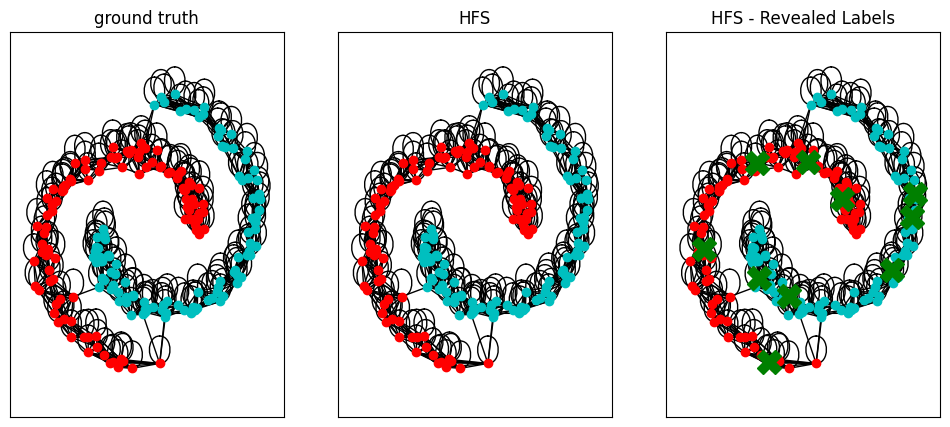

Soft=False, Accuracy=1.0


In [5]:
seed = 42
params = {
    'laplacian_regularization': 0.0,
    'var': 1.0,
    'eps': None,
    'k': 10,
    'laplacian_normalization': 'unn',
    'c_l': 0.99,
    'c_u': 0.1
}
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=0, soft=False, dataset='data_2moons_hfs.mat',
                                                 plot=True, seed=seed, **params)

>Here, a 100% accuracy is obtained, showing that HFS is able to correctly infer the labels of all unlabeled points.

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

In [6]:
np.random.seed(42)

n_errors = 0

for ii in range(20):
    try:
        X, Y, hard_labels, hard_accuracy = two_moons_hfs(
            l=4, l_noisy=0, soft=False,
            dataset='data_2moons_hfs.mat',
            plot=False, seed=None, **params
        )
        print(f"Accuracy: {hard_accuracy}")
    except Exception as e:
        n_errors += 1
        print("Error")

print(f"\nNumber of errors: {n_errors} / 20")

Soft=False, Accuracy=0.99
Accuracy: 0.99
Soft=False, Accuracy=0.82
Accuracy: 0.82
Soft=False, Accuracy=0.815
Accuracy: 0.815
Soft=False, Accuracy=0.875
Accuracy: 0.875
Soft=False, Accuracy=0.825
Accuracy: 0.825
Soft=False, Accuracy=0.85
Accuracy: 0.85
Soft=False, Accuracy=0.74
Accuracy: 0.74
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Error
Soft=False, Accuracy=0.835
Accuracy: 0.835
Soft=False, Accuracy=0.97
Accuracy: 0.97
Soft=False, Accuracy=0.995
Accuracy: 0.995
Soft=False, Accuracy=0.86
Accuracy: 0.86
Soft=False, Accuracy=0.995
Accuracy: 0.995
Soft=False, Accuracy=0.995
Accuracy: 0.995
Soft=False, Accuracy=0.85
Accuracy: 0.85
Soft=False, Accuracy=0.795
Accuracy: 0.795
Soft=False, Accuracy=0.76
Accuracy: 0.76
Soft=False, Accuracy=1.0
Accuracy: 1.0

Number of errors: 1 / 20


In [7]:
np.random.seed(42)

n_errors = 0

for ii in range(20):
    try:
        X, Y, hard_labels, hard_accuracy = two_moons_hfs(
            l=4, l_noisy=0, soft=False,
            dataset='data_2moons_hfs_large.mat',
            plot=False, seed=None, **params
        )
        print(f"Accuracy: {hard_accuracy}")
    except Exception as e:
        n_errors += 1
        print("Error")

print(f"\nNumber of errors: {n_errors} / 20")

Error
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0
Error
Soft=False, Accuracy=1.0
Accuracy: 1.0
Soft=False, Accuracy=1.0
Accuracy: 1.0

Number of errors: 2 / 20


>With only four labeled samples, the randomly revealed points may all belong to the same class. In this case, HFS lacks class diversity and can fail to correctly propagate labels. When this happened, an exception is raised : ``only one class in training data ! ``

>To fix this issue, we can set **per_class = True** when calling the ``mask_labels`` function.

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

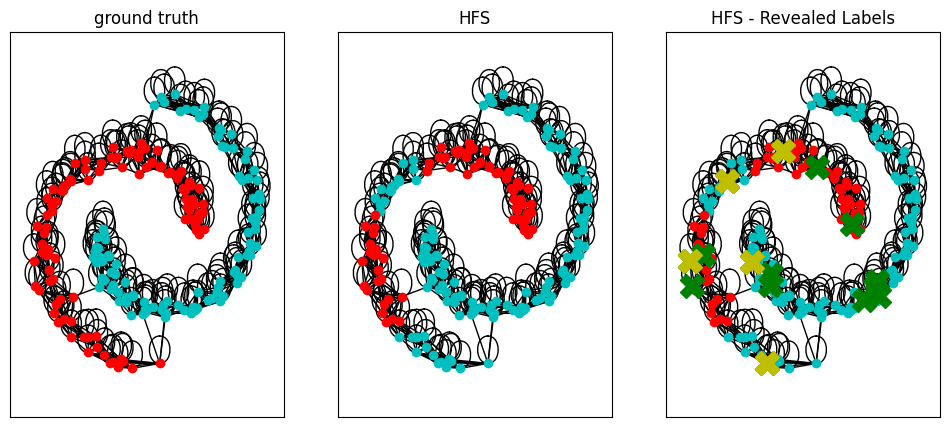

Soft=False, Accuracy=0.855


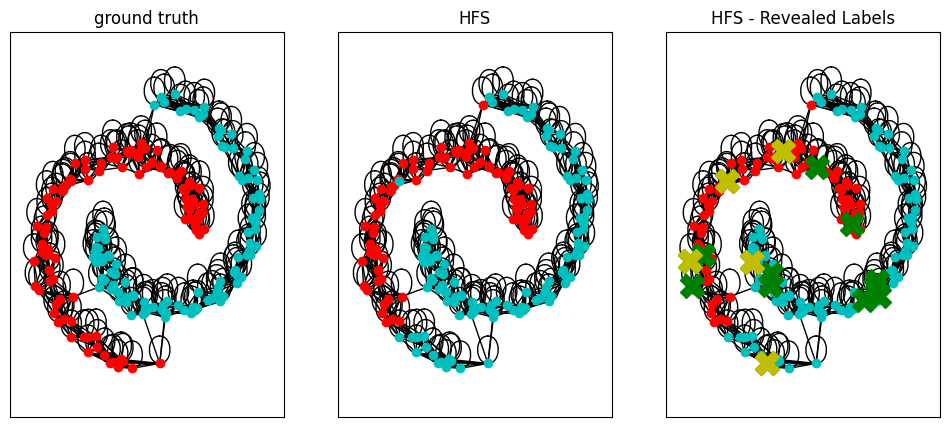

Soft=True, Accuracy=0.92
Run 01 | Hard: 0.855 | Soft: 0.920
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.92
Run 02 | Hard: 0.855 | Soft: 0.920
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.92
Run 03 | Hard: 0.855 | Soft: 0.920
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.92
Run 04 | Hard: 0.855 | Soft: 0.920
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.92
Run 05 | Hard: 0.855 | Soft: 0.920
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.92
Run 06 | Hard: 0.855 | Soft: 0.920
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.92
Run 07 | Hard: 0.855 | Soft: 0.920
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.92
Run 08 | Hard: 0.855 | Soft: 0.920
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.92
Run 09 | Hard: 0.855 | Soft: 0.920
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.92
Run 10 | Hard: 0.855 | Soft: 0.920
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.92
Run 11 | Hard: 0.855 | Soft: 0.920
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.92
Run 12 | Hard: 0.8

In [8]:
# Comparing
seed = 5  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'

hard_acc = []
soft_acc = []


for ii in range(20):
    plot = True if ii == 0 else False
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                     plot=plot, seed=seed, **params)
    X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset, plot=plot, seed=seed, **params)


    
    hard_acc.append(hard_accuracy)
    soft_acc.append(soft_accuracy   )

    print(f"Run {ii+1:02d} | Hard: {hard_accuracy:.3f} | Soft: {soft_accuracy:.3f}")

print("\nSummary over runs")
print(f"Hard HFS  : mean = {np.mean(hard_acc):.3f}, std = {np.std(hard_acc):.3f}")
print(f"Soft HFS  : mean = {np.mean(soft_acc):.3f}, std = {np.std(soft_acc):.3f}")



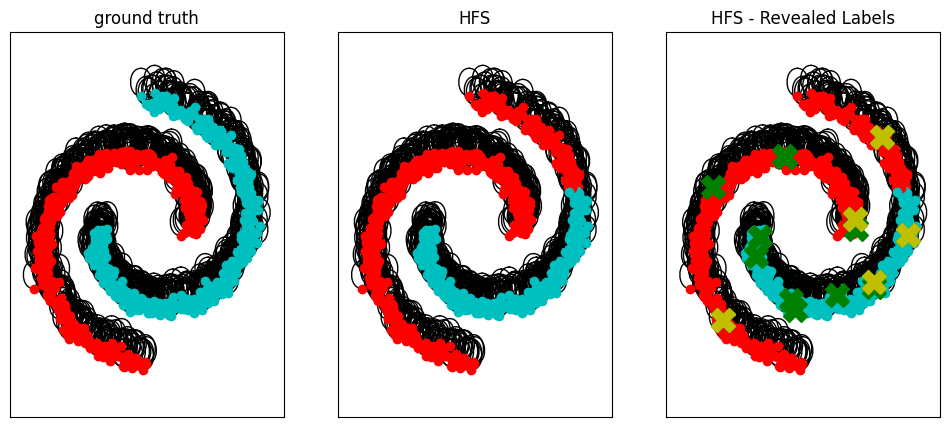

Soft=False, Accuracy=0.878


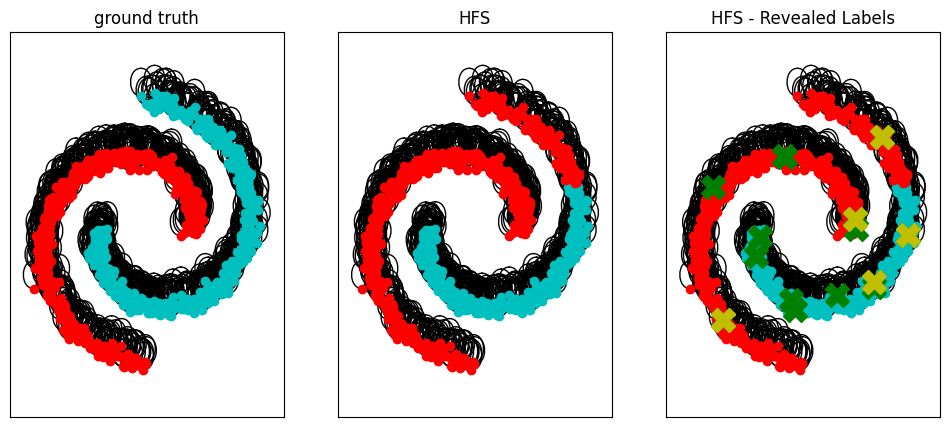

Soft=True, Accuracy=0.881
Run 01 | Hard: 0.878 | Soft: 0.881
Soft=False, Accuracy=0.878
Soft=True, Accuracy=0.881
Run 02 | Hard: 0.878 | Soft: 0.881
Soft=False, Accuracy=0.878
Soft=True, Accuracy=0.881
Run 03 | Hard: 0.878 | Soft: 0.881
Soft=False, Accuracy=0.878
Soft=True, Accuracy=0.881
Run 04 | Hard: 0.878 | Soft: 0.881
Soft=False, Accuracy=0.878
Soft=True, Accuracy=0.881
Run 05 | Hard: 0.878 | Soft: 0.881
Soft=False, Accuracy=0.878
Soft=True, Accuracy=0.881
Run 06 | Hard: 0.878 | Soft: 0.881
Soft=False, Accuracy=0.878
Soft=True, Accuracy=0.881
Run 07 | Hard: 0.878 | Soft: 0.881
Soft=False, Accuracy=0.878
Soft=True, Accuracy=0.881
Run 08 | Hard: 0.878 | Soft: 0.881
Soft=False, Accuracy=0.878
Soft=True, Accuracy=0.881
Run 09 | Hard: 0.878 | Soft: 0.881
Soft=False, Accuracy=0.878
Soft=True, Accuracy=0.881
Run 10 | Hard: 0.878 | Soft: 0.881
Soft=False, Accuracy=0.878
Soft=True, Accuracy=0.881
Run 11 | Hard: 0.878 | Soft: 0.881
Soft=False, Accuracy=0.878
Soft=True, Accuracy=0.881
Run 12

In [9]:
# Comparing
seed = 5  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs_large.mat' # Try also 'data_2moons_hfs_large.mat'

hard_acc = []
soft_acc = []


for ii in range(20):
    plot = True if ii == 0 else False
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                     plot=plot, seed=seed, **params)
    X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset, plot=plot, seed=seed, **params)


    
    hard_acc.append(hard_accuracy)
    soft_acc.append(soft_accuracy   )

    print(f"Run {ii+1:02d} | Hard: {hard_accuracy:.3f} | Soft: {soft_accuracy:.3f}")

print("\nSummary over runs")
print(f"Hard HFS  : mean = {np.mean(hard_acc):.3f}, std = {np.std(hard_acc):.3f}")
print(f"Soft HFS  : mean = {np.mean(soft_acc):.3f}, std = {np.std(soft_acc):.3f}")



> In this question, we performed both Hard HFS and Soft HFS on the datasets  `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.

> We used the previously selected parameters, which are:

- `laplacian_regularization = 0.0`  
- `var = 1.0`  
- `k = 10`  
- `laplacian_normalization = 'unn'`  
- `c_l = 0.99`  
- `c_u = 0.1`  

> For both experiments, Soft HFS performed better, achieving an accuracy of approximately 92% on `data_2moons_hfs.mat` and 85% on `data_2moons_hfs_large.mat`. In contrast, Hard HFS*reached accuracies of about 85% and 87% respectively.

>This difference can be explained by the fact that Soft HFS allows a smoother propagation of label information across the graph. By relaxing the hard label constraints, Soft HFS is more robust to noise and local inconsistencies in the graph structure, especially near class boundaries.   On the other hand, Hard HFS strictly enforces the initial labels, which may lead to error propagation when the neighborhood graph is imperfect.

>Overall, Soft HFS appears to be a better choice to mitigate the propagation of errors.  


## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

### Question 2.1 - How did you manage to label more than two classes?

>To handle more than two classes, we extend HFS to the multi-class setting by using a one-hot encoding of the labels. Each labeled node is represented by a vector indicating its class, while unlabeled nodes are represented by a zero vector.

>The harmonic function solution is then computed independently for each class (in the hard case) or jointly for all classes (in the soft case), producing a score for each class and each node. The final class assignment is obtained by selecting, for each node, the class with the highest score.


### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person). 


> For the small dataset (10 images per person), the best accuracy obtained with Hard HFS is 0.85. This result was achieved after performing a grid search to select the optimal hyperparameters.
On the augmented dataset (50 images per person), Hard HFS reaches a best accuracy of 0.648. As for the small dataset, a grid search was conducted to determine the best combination of parameters.

> Using Soft HFS on the small dataset, the best accuracy obtained is 0.84. The optimal parameters were selected via grid search. On the augmented dataset, Soft HFS achieves a best accuracy of 0.65 after hyperparameter tuning using grid search.

### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

>The accuracy decreases when using the augmented dataset compared to the small dataset because the classification task becomes more challenging. The augmented dataset introduces a higher intra-class variability. As a result, samples belonging to the same class are less tightly clustered in the feature space.

>HFS is a graph-based method and strongly depends on the quality of the similarity graph. When more heterogeneous data is added, the local neighborhoods defined by the k-NN graph may contain samples from different classes more frequently. This degrades the label propagation process and increases the risk of propagating incorrect labels across the graph.

>Therefore, using additional data does not always improve performance. While more data can be beneficial when it provides complementary and well-structured information, it can also introduce noise and blur class boundaries. In such cases, especially with graph-based semi-supervised methods, the added complexity can outweigh the benefits and lead to a decrease in accuracy.

In [5]:
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import cv2
import os
import pandas as pd

from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented

In [6]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 1.0
params_face_rec['var'] = 10000.0
params_face_rec['eps'] = None
params_face_rec['k'] = None
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = None
params_face_rec['c_u'] = None

In [42]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(float)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

In [14]:
# 10 images per person
np.random.seed(456)   # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data(preprocess_image)

# # 50 images per person
# images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
# plot_image_data_augmented(images_a)

# Uncomment below if you want to visualize the images
# plot_image_data(images)
# print(images.shape)
# print(masked_labels.reshape(-1, 10))

#### Hard HFS

##### Small Dataset

In [15]:
k   = [1, 2, 3, 5 ,10, 15, 20, 25, 30]
var = [20, 50, 100, 200, 500, 1000]
reg = [1e-3, 1e-2, 1e-1, 0.2, 0.5, 0.8]

results = []

for k_i in k:
    params_face_rec['k'] = k_i
    for var_i in var:
        params_face_rec['var'] = var_i
        for reg_i in reg:
            params_face_rec['laplacian_regularization'] = reg_i
            L = build_laplacian_regularized(
                images,
                laplacian_regularization=params_face_rec['laplacian_regularization'],
                var=params_face_rec['var'],
                eps=params_face_rec['eps'],
                k=params_face_rec['k'],
                laplacian_normalization=params_face_rec['laplacian_normalization']
            )
            predicted_labels, f = compute_hfs(L, masked_labels, soft=False, **params_face_rec)
            accuracy = np.mean(predicted_labels == labels.squeeze())
            results.append({
                'k': k_i,
                'var': var_i,
                'reg': reg_i,
                'accuracy': accuracy
            })

df = pd.DataFrame(results)
print(df.sort_values(by='accuracy', ascending=False).head(10))
            

      k  var  reg  accuracy
159  10  100  0.2      0.85
130   5  200  0.5      0.85
160  10  100  0.5      0.85
122   5  100  0.1      0.85
196  15  100  0.5      0.85
195  15  100  0.2      0.85
123   5  100  0.2      0.85
303  30  100  0.2      0.85
304  30  100  0.5      0.85
129   5  200  0.2      0.85


In [16]:
# graph Laplacian
params_face_rec["k"] = 10
params_face_rec["var"] = 100.0
params_face_rec["laplacian_regularization"] = 0.2
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

Accuracy =  0.85


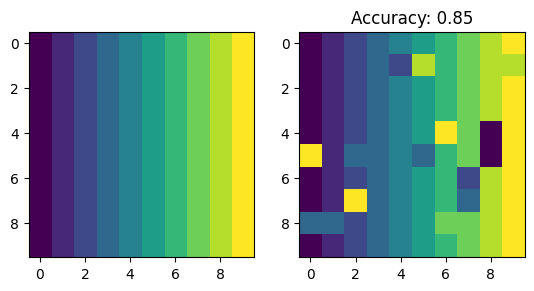

In [ ]:

# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=False, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy = ", accuracy)

plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

##### Large Dataset

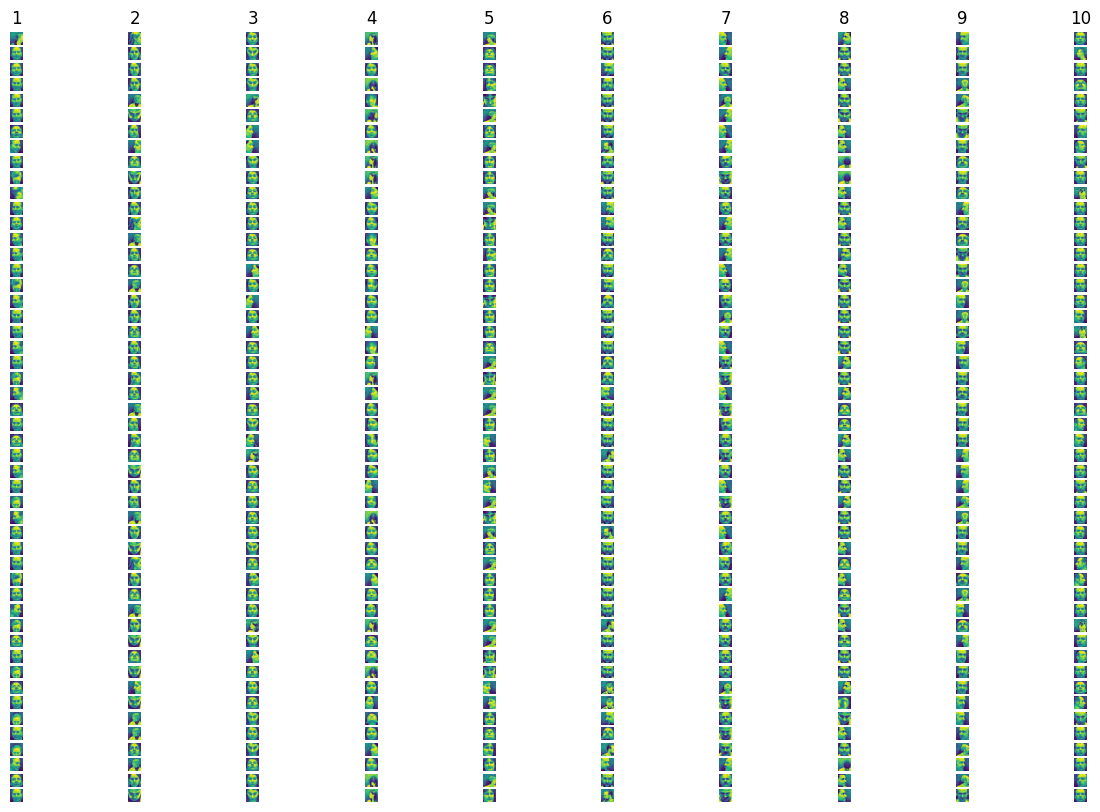

In [19]:
# 50 images per person
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
plot_image_data_augmented(images_a)

#Uncomment below if you want to visualize the images
#plot_image_data(images)
#print(images.shape)
#print(masked_labels.reshape(-1, 10))

In [20]:
k   = [1, 2, 3, 5 ,10, 15, 20, 25, 30]
var = [20, 50, 100, 200, 500, 1000]
reg = [1e-3, 1e-2, 1e-1, 0.2, 0.5, 0.8]

results = []

for k_i in k:
    params_face_rec['k'] = k_i
    for var_i in var:
        params_face_rec['var'] = var_i
        for reg_i in reg:
            params_face_rec['laplacian_regularization'] = reg_i
            L = build_laplacian_regularized(
                images_a,
                laplacian_regularization=params_face_rec['laplacian_regularization'],
                var=params_face_rec['var'],
                eps=params_face_rec['eps'],
                k=params_face_rec['k'],
                laplacian_normalization=params_face_rec['laplacian_normalization']
            )
            predicted_labels, f = compute_hfs(L, masked_labels_a, soft=False, **params_face_rec)
            accuracy = np.mean(predicted_labels == labels_a.squeeze())
            results.append({
                'k': k_i,
                'var': var_i,
                'reg': reg_i,
                'accuracy': accuracy
            })

df = pd.DataFrame(results)
print(df.sort_values(by='accuracy', ascending=False).head(10))
            

      k  var   reg  accuracy
296  30   50  0.10     0.648
253  25   20  0.01     0.648
188  15   50  0.10     0.648
217  20   20  0.01     0.648
289  30   20  0.01     0.648
224  20   50  0.10     0.648
260  25   50  0.10     0.648
181  15   20  0.01     0.646
123   5  100  0.20     0.644
145  10   20  0.01     0.644


In [27]:
# graph Laplacian
params_face_rec["k"] = 30
params_face_rec["var"] = 50
params_face_rec["laplacian_regularization"] = 0.1
L = build_laplacian_regularized(images_a, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

Accuracy =  0.648


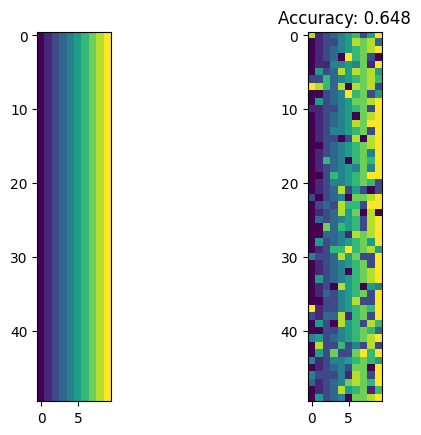

In [ ]:
# Run HFS
predicted_labels_a, f = compute_hfs(L, masked_labels_a, soft=False, **params_face_rec)
accuracy = np.equal(predicted_labels_a, labels_a).mean()
print("Accuracy = ", accuracy)

plt.subplot(121)
plt.imshow(labels_a.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels_a.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

#### Soft HFS

##### Small Dataset 

In [30]:
k  = [1, 2, 3, 5 ,10, 15, 20, 25, 30]
var = [20, 50, 100, 200, 500, 1000]
reg = [1e-3, 1e-2, 1e-1, 0.2, 0.5, 0.8]
c_l = [0.75, 0.9, 0.95, 0.99]
c_u = [0.05, 0.1, 0.2]

results = []

for k_i in k:
    params_face_rec["k"] = k_i
    for var_i in var:
        params_face_rec["var"] = var_i
        for reg_i in reg:
            params_face_rec["laplacian_regularization"] = reg_i

            L = build_laplacian_regularized(
                images,
                laplacian_regularization=reg_i,
                var=var_i,
                eps=params_face_rec["eps"],
                k=k_i,
                laplacian_normalization=params_face_rec["laplacian_normalization"]
            )

            for c_l_i in c_l:
                params_face_rec["c_l"] = c_l_i
                for c_u_i in c_u:
                    params_face_rec["c_u"] = c_u_i

                    predicted_labels, f = compute_hfs(
                        L,
                        masked_labels,
                        soft=True,              
                        **params_face_rec
                    )

                    accuracy = np.mean(predicted_labels == labels.squeeze())

                    results.append({
                        "k": k_i,
                        "var": var_i,
                        "reg": reg_i,
                        "c_l": c_l_i,
                        "c_u": c_u_i,
                        "accuracy": accuracy
                    })

df = pd.DataFrame(results)
print(df.sort_values(by="accuracy", ascending=False).head(10))

       k  var    reg   c_l   c_u  accuracy
3625  30  100  0.100  0.75  0.10      0.84
3607  30  100  0.001  0.95  0.10      0.84
1914  10  100  0.200  0.95  0.05      0.84
3210  25  100  0.200  0.95  0.05      0.84
1911  10  100  0.200  0.90  0.05      0.84
3602  30  100  0.001  0.75  0.20      0.84
3604  30  100  0.001  0.90  0.10      0.84
3605  30  100  0.001  0.90  0.20      0.84
1906  10  100  0.100  0.99  0.10      0.84
3608  30  100  0.001  0.95  0.20      0.84


Accuracy =  0.84


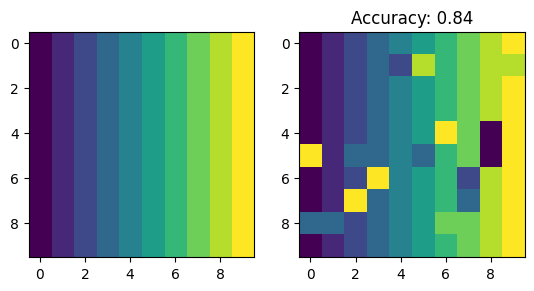

In [35]:
# graph Laplacian
params_face_rec["k"] = 30
params_face_rec["var"] = 100
params_face_rec["laplacian_regularization"] = 0.1
params_face_rec["c_l"] = 0.75
params_face_rec["c_u"] = 0.1
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])
# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy = ", accuracy)


plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

##### Large Dataset

In [33]:
k  = [1, 2, 3, 5 ,10, 15, 20, 25, 30]
var = [20, 50, 100, 200, 500, 1000]
reg = [1e-3, 1e-2, 1e-1, 0.2, 0.5, 0.8]
c_l = [0.75, 0.9, 0.95, 0.99]
c_u = [0.05, 0.1, 0.2]

results = []

for k_i in k:
    params_face_rec["k"] = k_i
    for var_i in var:
        params_face_rec["var"] = var_i
        for reg_i in reg:
            params_face_rec["laplacian_regularization"] = reg_i

            L = build_laplacian_regularized(
                images_a,
                laplacian_regularization=reg_i,
                var=var_i,
                eps=params_face_rec["eps"],
                k=k_i,
                laplacian_normalization=params_face_rec["laplacian_normalization"]
            )

            for c_l_i in c_l:
                params_face_rec["c_l"] = c_l_i
                for c_u_i in c_u:
                    params_face_rec["c_u"] = c_u_i

                    predicted_labels, f = compute_hfs(
                        L,
                        masked_labels_a,
                        soft=True,              
                        **params_face_rec
                    )

                    accuracy = np.mean(predicted_labels == labels_a.squeeze())

                    results.append({
                        "k": k_i,
                        "var": var_i,
                        "reg": reg_i,
                        "c_l": c_l_i,
                        "c_u": c_u_i,
                        "accuracy": accuracy
                    })

df = pd.DataFrame(results)
print(df.sort_values(by="accuracy", ascending=False).head(10))

       k  var    reg   c_l   c_u  accuracy
3474  30   20  0.010  0.95  0.05      0.65
2175  15   20  0.010  0.90  0.05      0.65
2169  15   20  0.001  0.99  0.05      0.65
2166  15   20  0.001  0.95  0.05      0.65
2163  15   20  0.001  0.90  0.05      0.65
2160  15   20  0.001  0.75  0.05      0.65
3530  30   50  0.001  0.75  0.20      0.65
3541  30   50  0.010  0.75  0.10      0.65
2666  20   50  0.001  0.75  0.20      0.65
3552  30   50  0.100  0.75  0.05      0.65


Accuracy =  0.65


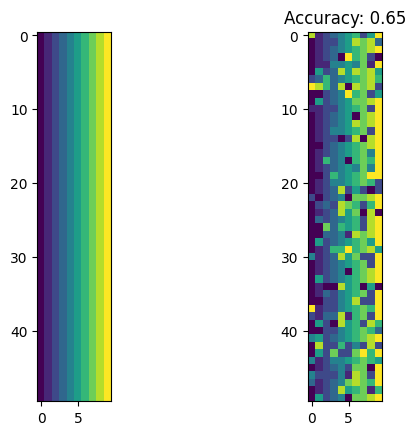

In [34]:
# graph Laplacian
params_face_rec["k"] = 30
params_face_rec["var"] = 20
params_face_rec["laplacian_regularization"] = 0.01
params_face_rec["c_l"] = 0.95
params_face_rec["c_u"] = 0.05
L = build_laplacian_regularized(images_a, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])
# Run HFS
predicted_labels_a, f = compute_hfs(L, masked_labels_a, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels_a, labels_a).mean()
print("Accuracy = ", accuracy)

plt.subplot(121)
plt.imshow(labels_a.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels_a.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`


Here are some results I got : 

![macron](results/macron.png)
![bill](results/bill.png)
    
### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import sys
from scipy.spatial import distance
import scipy.io as sio

from helper_online_ssl import create_user_profile, online_face_recognition

In [9]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = 1.0
params_online_ssl['var'] = 10000.0
params_online_ssl['eps'] = None
params_online_ssl['k'] = None
params_online_ssl['laplacian_normalization'] = 'unn'
params_online_ssl['c_l'] = None
params_online_ssl['c_u'] = None

In [ ]:
class IncrementalKCenters:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=50):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels
        
        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None
    
    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """       
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])


    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.
        
        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample
        
        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """

        assert (self.image_dimension == len(face)), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                # Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False

            """
            Find c_rep and c_add following Algorithm 1.

            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                    with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """

            nbr = self.centroids_distances.shape[0]
            sorted_idx = np.argsort(self.centroids_distances.ravel())

            for idx in sorted_idx:
                c_1 = idx // nbr
                c_2 = idx % nbr
                if not (self.taboo[c_1] and self.taboo[c_2]):
                    break

            if self.taboo[c_1] and not self.taboo[c_2]:
                c_rep = c_1
                c_add = c_2
            elif self.taboo[c_2] and not self.taboo[c_1]:
                c_rep = c_2
                c_add = c_1
            else:
                if self.V[c_1] >= self.V[c_2]:
                    c_rep = c_1
                    c_add = c_2
                else:
                    c_rep = c_2
                    c_add = c_1

            """
            Update data structures: self.centroids and self.V
            """
            self.V[c_rep] += self.V[c_add]
            self.centroids[c_add] = face
            self.V[c_add] = 1
            self.Y[c_add] = 0   
            self.last_face = c_add

            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(
                np.array([self.centroids[c_add]]),
                self.centroids
            )[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            self.centroids = np.vstack([self.centroids, face])
            self.Y = np.append(self.Y, 0)
            self.last_face = self.centroids.shape[0] - 1

    def online_ssl_compute_solution(self):
        """

        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)
            
        # Build quantized graph and its regularized Laplacian
        W = build_similarity_graph(
            self.centroids,
            var=params_online_ssl['var'],
            eps=params_online_ssl['eps'],
            k=params_online_ssl['k'],
        )

        L = build_laplacian(W=W,laplacian_normalization=params_online_ssl['laplacian_normalization'])
        Q = V @ L + params_online_ssl['laplacian_regularization'] * np.eye(L.shape[0])

        # Compute the hard HFS solution f. 
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1 
        label_scores = []
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            maximum = np.max(f[self.last_face])
            if maximum < 0.8:
                label = "unknown"
            label_scores.append((label, score))

        return label_scores
      


In [28]:
create_user_profile('Ilan Bacry')         # choose your names here :)
# create_user_profile('alice')
# online_face_recognition(['bob', 'alice'], IncrementalKCenters, n_pictures=15)

New profile created at path data/faces/Ilan Bacry
Image 1 saved at data/faces/Ilan Bacry/img_1.bmp
Image 2 saved at data/faces/Ilan Bacry/img_2.bmp
Image 3 saved at data/faces/Ilan Bacry/img_3.bmp
Image 4 saved at data/faces/Ilan Bacry/img_4.bmp
Image 5 saved at data/faces/Ilan Bacry/img_5.bmp
Image 6 saved at data/faces/Ilan Bacry/img_6.bmp
Image 7 saved at data/faces/Ilan Bacry/img_7.bmp
Image 8 saved at data/faces/Ilan Bacry/img_8.bmp
Image 9 saved at data/faces/Ilan Bacry/img_9.bmp
Image 10 saved at data/faces/Ilan Bacry/img_10.bmp
Image 11 saved at data/faces/Ilan Bacry/img_11.bmp
Image 12 saved at data/faces/Ilan Bacry/img_12.bmp
Image 13 saved at data/faces/Ilan Bacry/img_13.bmp
Image 14 saved at data/faces/Ilan Bacry/img_14.bmp
Image 15 saved at data/faces/Ilan Bacry/img_15.bmp
Image 16 saved at data/faces/Ilan Bacry/img_16.bmp
Image 17 saved at data/faces/Ilan Bacry/img_17.bmp
Image 18 saved at data/faces/Ilan Bacry/img_18.bmp
Image 19 saved at data/faces/Ilan Bacry/img_19.bmp

In [35]:
online_face_recognition(['Ilan Bacry'], IncrementalKCenters, n_pictures=15)

Profile found with 57 images.
saved
Image saved at results/frame.png
saved
Image saved at results/frame.png


In [30]:
create_user_profile("Macron", video_filename="data/Macron.mp4")  

New profile created at path data/faces/Macron
Image 1 saved at data/faces/Macron/img_1.bmp
Image 2 saved at data/faces/Macron/img_2.bmp
Image 3 saved at data/faces/Macron/img_3.bmp
Image 4 saved at data/faces/Macron/img_4.bmp
Image 5 saved at data/faces/Macron/img_5.bmp
Image 6 saved at data/faces/Macron/img_6.bmp
Image 7 saved at data/faces/Macron/img_7.bmp
Image 8 saved at data/faces/Macron/img_8.bmp
Image 9 saved at data/faces/Macron/img_9.bmp
Image 10 saved at data/faces/Macron/img_10.bmp
Image 11 saved at data/faces/Macron/img_11.bmp
Image 12 saved at data/faces/Macron/img_12.bmp
Image 13 saved at data/faces/Macron/img_13.bmp
Image 14 saved at data/faces/Macron/img_14.bmp
Image 15 saved at data/faces/Macron/img_15.bmp
Image 16 saved at data/faces/Macron/img_16.bmp
Image 17 saved at data/faces/Macron/img_17.bmp
Image 18 saved at data/faces/Macron/img_18.bmp
Image 19 saved at data/faces/Macron/img_19.bmp
Image 20 saved at data/faces/Macron/img_20.bmp
Image 21 saved at data/faces/Mac

In [34]:
online_face_recognition(['Macron'], IncrementalKCenters, n_pictures=15, video_filename="data/Bill.mp4")

Profile found with 40 images.


In [32]:
online_face_recognition(['Macron'], IncrementalKCenters, n_pictures=15, video_filename="data/Macron.mp4")

Profile found with 40 images.
saved
Image saved at results/frame.png
saved
Image saved at results/frame.png
saved
Image saved at results/frame.png
saved
Image saved at results/frame.png
saved
Image saved at results/frame.png
saved
Image saved at results/frame.png


### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

* Tips: 
    * Think back to the idea of incremental clustering as unsupervised classification


> In the current setting, faces are classified either as belonging to a known identity or as unknown when their confidence score is below a fixed threshold. However, instead of discarding unknown faces, the algorithm can be extended to learn new identities automatically over time.

> Unknown faces can be stored as unlabeled centroids and treated as clusters in an incremental clustering framework. Each time a similar face is observed again, the corresponding centroid is updated and a multiplicity counter is increased. Faces that appear only a few times remain labeled as unknown, which prevents the creation of artificial classes due to noise or occasional observations.

> When the multiplicity of an unlabeled centroid exceeds a predefined threshold, the algorithm can assume that this face corresponds to a new recurring identity. The centroid is then promoted to a new class and automatically assigned a label. From that point on, this new class is treated like any other known identity and is integrated into the semi-supervised graph used for classification.

> This approach  allows the model to reject rare faces while progressively discovering and learning new identities in an online manner.
    
### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:
* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.
* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

In [43]:
import os
import cv2
import numpy as np
from imageio import imread
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors

In [44]:
def load_faces_for_ml(
    base_dir="data/extended_dataset",
    persons=None,
    max_images_per_person=50,
    preprocess_fn=None,
    seed=0
):
    rng = np.random.default_rng(seed)
    detector = cv2.CascadeClassifier(
        os.path.join("data", "haarcascade_frontalface_default.xml")
    )

    X, y = [], []

    if persons is None:
        persons = sorted(os.listdir(base_dir))

    for label_id, person in enumerate(persons, start=1):
        folder = os.path.join(base_dir, str(person))
        files = rng.permutation(os.listdir(folder))[:max_images_per_person]

        for fname in files:
            img = imread(os.path.join(folder, fname))
            faces = detector.detectMultiScale(img)

            if len(faces) == 0:
                continue

            x, y0, w, h = max(faces, key=lambda b: np.hypot(b[2], b[3]))
            face = cv2.cvtColor(img[y0:y0+h, x:x+w], cv2.COLOR_BGR2GRAY)

            if preprocess_fn is not None:
                face = preprocess_fn(face)

            X.append(face.flatten())
            y.append(label_id)

    return np.asarray(X), np.asarray(y)

#### Supervised vs Semi-Supervised

##### Protocol

> We consider a transductive learning setting in which all samples to be classified are available at training time.

> A subset of faces is selected and only a small number of labels l per class are revealed, while the remaining faces are treated as unlabeled. Two approaches are compared:

- Supervised learning: a linear SVM is trained only on the l labeled faces. Dimensionality reduction is performed using PCA, followed by standardization and linear classification.

- Semi-supervised learning: a Hard HFS is trained using both labeled and unlabeled faces (l + u). 

> Both methods are evaluated on the same set of faces in order to ensure a fair comparison.

##### Results
- Supervised SVM accuracy: 0.947   (here we didn't use GridSearch for finding optimal hyperparameters)
- Semi-supervised HFS accuracy: 0.944 (here we implemented a GridSearch)

##### Observations
>The supervised and semi-supervised approaches achieve very similar performance in this transductive setting. Despite having access to far fewer labeled samples, the Hard HFS method reaches an accuracy close to that of the supervised SVM.

>These results highlight the effectiveness of semi-supervised learning when labeled data is scarce, while confirming that supervised learning remains a strong baseline when sufficient labels are available.

In [160]:
X, y = load_faces_for_ml(preprocess_fn=preprocess_image)

X_seen, _, y_seen, _ = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Y_seen_masked = mask_labels(y_seen, l=20, per_class=True)

/var/folders/bg/rn6v3_d90s7b47lrzgg2ds0c0000gn/T/ipykernel_51014/1074353050.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(os.path.join(folder, fname))


In [169]:
# Supervised
seen_l_idx = (Y_seen_masked != 0)

X_l = X_seen[seen_l_idx]
y_l = y_seen[seen_l_idx]

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=30, whiten=True, random_state=42)),
    ("svm", SVC(kernel="linear", C=1))
])

svm.fit(X_l, y_l)

svm_pred = svm.predict(X_seen)
svm_acc = accuracy_score(svm_pred, y_seen)

In [166]:
# Semi-supervised
params_hfs = {}
k_list   = [1, 2, 3, 5, 8, 10, 20, 30, 40]
var_list = [20, 50, 100, 200, 400, 500]
reg_list = [1e-2, 3e-2, 0.1, 0.2, 0.5, 0.7, 0.9, 1.0]

results_hfs = []

for k_i in k_list:
    params_hfs["k"] = k_i
    for var_i in var_list:
        params_hfs["var"] = var_i
        for reg_i in reg_list:
            params_hfs["laplacian_regularization"] = reg_i

            L_seen = build_laplacian_regularized(
                X_seen,
                laplacian_regularization=reg_i,
                var=var_i,
                k=k_i,
                laplacian_normalization="unn",
            )


            hfs_pred, _ = compute_hfs(
                L_seen,
                Y_seen_masked,
                soft=False,
                **params_hfs
            )

            seen_acc = np.mean(hfs_pred == y_seen)

            results_hfs.append({
                "method": "HFS",
                "k": k_i,
                "var": var_i,
                "reg": reg_i,
                "seen_accuracy": seen_acc,
            })

In [170]:
df_hfs = pd.DataFrame(results_hfs)

best_hfs = df_hfs.sort_values(
    by="seen_accuracy", ascending=False
).iloc[0]

print("Supervised vs Semi-supervised (transductive)")
print(f"  SVM accuracy : {svm_acc:.3f}")
print(f"  HFS accuracy : {best_hfs['seen_accuracy']:.3f}")

Supervised vs Semi-supervised (transductive)
  SVM accuracy : 0.947
  HFS accuracy : 0.944


#### Inductive vs Transductive 

##### Protocol

> We consider both transductive and inductive learning settings to evaluate the ability of the models to generalize to unseen data.

> A subset of faces is selected and only a small number of labels l per class are revealed, while the remaining faces are treated as unlabeled. The dataset is split into a seen set, available during training and an unseen set, never observed by the transductive model. Two approaches are compared:

- Transductive learning: a Hard HFS is trained using both labeled and unlabeled faces from the seen set (l + u). Since HFS is transductive, labels for unseen faces are obtained by assigning each unseen sample the label of its nearest neighbor in the seen set.

- Inductive learning: a supervised SVM is trained only on the l labeled faces from the seen set. Dimensionality reduction is performed using PCA, followed by standardization and classification. The learned decision function is then directly applied to both seen and unseen faces.

Both methods are evaluated on the seen and unseen sets in order to compare their behavior in transductive and inductive settings.

##### Results
- Hard HFS (transductive)
  - Seen accuracy: 0.95
  - Unseen accuracy: 0.86

- Supervised SVM (inductive)
  - Seen accuracy: 0.956
  - Unseen accuracy: 0.884

##### Observations
>The Hard HFS model achieves strong performance on the seen data, reaching an accuracy comparable to that of the supervised SVM. This confirms the ability of graph-based semi-supervised learning to effectively exploit the structure of the data manifold when all samples are available at training time.

>On unseen data, the supervised SVM outperforms Hard HFS. This behavior is expected, as the inductive model learns an explicit decision function that generalizes naturally to new samples, whereas the transductive HFS relies on a nearest-neighbor approximation to extend predictions beyond the seen set.

In [45]:
X, y = load_faces_for_ml(preprocess_fn=preprocess_image)

X_seen, X_unseen, y_seen, y_unseen = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Y_seen_masked = mask_labels(y_seen, l=20, per_class=True)
seen_l_idx = (Y_seen_masked != 0)

X_seen_l = X_seen[seen_l_idx]
y_seen_l = y_seen[seen_l_idx]

/var/folders/bg/rn6v3_d90s7b47lrzgg2ds0c0000gn/T/ipykernel_44565/1074353050.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(os.path.join(folder, fname))


##### Semi Supervised

In [48]:
X,y = load_faces_for_ml(preprocess_fn=preprocess_image)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
Y_train_masked = mask_labels(y_train, l=20, per_class=True)

/var/folders/bg/rn6v3_d90s7b47lrzgg2ds0c0000gn/T/ipykernel_44565/1074353050.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(os.path.join(folder, fname))


In [49]:
params_hfs = {
    "laplacian_regularization": 0.5,
    "laplacian_normalization": "unn",   
    "k": 10,                            
    "var": 1e4,                         
    "eps": None,                        
    "c_l": 0.9,
    "c_u": 0.0
}

In [50]:


k_list   = [1, 2, 3, 5, 8, 10,20,30,40,50]
var_list = [20, 50, 100, 200,400,500, 1000, 2000, 5000]
reg_list = [1e-2, 3e-2, 0.1, 0.2, 0.5,0.7,0.9, 1.0]

results = []

for k_i in k_list:
    params_hfs["k"] = k_i
    for var_i in var_list:
        params_hfs["var"] = var_i
        for reg_i in reg_list:
            params_hfs["laplacian_regularization"] = reg_i

            L_seen = build_laplacian_regularized(
                X_seen,
                laplacian_regularization=reg_i,
                var=var_i,
                eps=params_hfs["eps"],
                k=k_i,
                laplacian_normalization=params_hfs["laplacian_normalization"],
            )

            hfs_seen_pred, _ = compute_hfs(
                L_seen,
                Y_seen_masked,
                soft=False,
                **params_hfs
            )

            seen_acc = np.mean(hfs_seen_pred == y_seen)

            nn = NearestNeighbors(n_neighbors=1)
            nn.fit(X_seen)

            _, idx = nn.kneighbors(X_unseen)
            hfs_unseen_pred = hfs_seen_pred[idx[:, 0]]

            unseen_acc = np.mean(hfs_unseen_pred == y_unseen)

            results.append({
                "k": k_i,
                "var": var_i,
                "reg": reg_i,
                "seen_accuracy": seen_acc,
                "unseen_accuracy": unseen_acc,
            })

In [51]:
df = pd.DataFrame(results)

best = df.sort_values(by="seen_accuracy", ascending=False).iloc[0]

best_k   = int(best["k"])
best_var = float(best["var"])
best_reg = float(best["reg"])

print("Best hyperparameters for HFS:"
      f"  k = {best_k}, var = {best_var}, reg = {best_reg}")

seen_acc   = best["seen_accuracy"]
unseen_acc = best["unseen_accuracy"]

print("HFS (best hyperparameters)")
print(f"  Seen accuracy   : {seen_acc:.2f}")
print(f"  Unseen accuracy : {unseen_acc:.2f} ")

Best hyperparameters for HFS:  k = 10, var = 100.0, reg = 0.03
HFS (best hyperparameters)
  Seen accuracy   : 0.95
  Unseen accuracy : 0.86 


##### Supervised

In [153]:
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=30, whiten=True, random_state=42)),
    ("svm", SVC(kernel="linear", C=1))
])

pipe_svm.fit(X_seen_l, y_seen_l)

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,30
,copy,True
,whiten,True
,svd_solver,'auto'


In [154]:
param_grid = [
    {
        "pca__n_components": [20, 50, 80],
        "svm__kernel": ["linear"],
        "svm__C": [0.01, 0.1, 1, 10, 100],
    },
    {
        "pca__n_components": [20, 50, 80],
        "svm__kernel": ["rbf"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", "auto", 1e-3, 1e-2],
    }
]

In [155]:
grid = GridSearchCV(
    pipe_svm,
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_seen_l, y_seen_l)

Fitting 3 folds for each of 63 candidates, totalling 189 fits
[CV] END pca__n_components=20, svm__C=0.1, svm__kernel=linear; total time=   0.6s
[CV] END pca__n_components=20, svm__C=0.01, svm__kernel=linear; total time=   0.7s
[CV] END .pca__n_components=20, svm__C=1, svm__kernel=linear; total time=   0.9s
[CV] END pca__n_components=20, svm__C=0.1, svm__kernel=linear; total time=   0.8s
[CV] END .pca__n_components=20, svm__C=1, svm__kernel=linear; total time=   0.7s
[CV] END pca__n_components=20, svm__C=0.01, svm__kernel=linear; total time=   0.8s
[CV] END pca__n_components=20, svm__C=0.01, svm__kernel=linear; total time=   0.8s
[CV] END pca__n_components=20, svm__C=0.1, svm__kernel=linear; total time=   1.0s
[CV] END .pca__n_components=20, svm__C=1, svm__kernel=linear; total time=   0.5s
[CV] END pca__n_components=20, svm__C=100, svm__kernel=linear; total time=   0.5s
[CV] END pca__n_components=20, svm__C=10, svm__kernel=linear; total time=   0.5s
[CV] END pca__n_components=20, svm__C

,estimator,Pipeline(step...l='linear'))])
,param_grid,"[{'pca__n_components': [20, 50, ...], 'svm__C': [0.01, 0.1, ...], 'svm__kernel': ['linear']}, {'pca__n_components': [20, 50, ...], 'svm__C': [0.1, 1, ...], 'svm__gamma': ['scale', 'auto', ...], 'svm__kernel': ['rbf']}]"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [156]:
svm_seen_acc = accuracy_score(pipe_svm.predict(X_seen), y_seen)
svm_unseen_acc = accuracy_score(pipe_svm.predict(X_unseen), y_unseen)

print("SVM")
print("  Seen  :", svm_seen_acc)
print("  Unseen:", svm_unseen_acc)

SVM
  Seen  : 0.9560117302052786
  Unseen: 0.8837209302325582


#### Supervised vs Semi-supervised and Inductive vs Transductive

##### Protocol

> We consider both supervised and semi-supervised learning in inductive and transductive settings.

> All N faces from the seen set are fully labeled and used to train a supervised classifier. In parallel, a semi-supervised learner is trained using only l labeled faces and u unlabeled faces. Both models are evaluated on the N revealed faces and on an additional set of m unrevealed faces. Two approaches are compared:

- Supervised learning (inductive): a linear SVM is trained on the N fully labeled faces. Dimensionality reduction is performed using PCA, followed by standardization and linear classification. 

- Semi-supervised learning (transductive): a Hard HFS model is trained on the seen faces using l labeled and u unlabeled samples.  Since HFS is transductive, predictions on unseen faces are obtained by assigning each unseen sample the label of its nearest neighbor in the seen set.

>Both methods are evaluated on the N revealed faces and on the m unrevealed faces in order to compare supervised and semi-supervised learning under inductive and transductive assumptions.

#### Results
- Supervised SVM (trained on N labels)
  - Seen accuracy: 1.000
  - Unseen accuracy: 0.919

- Semi-supervised Hard HFS (trained on l + u)
  - Seen accuracy: 0.947
  - Unseen accuracy: 0.860 (via 1-NN projection)

#### Observations
>The supervised SVM achieves perfect accuracy on the seen data, which is expected since it is trained using all available labels. Its strong performance on unseen data further highlights the benefit of learning an explicit inductive decision function.

>The semi-supervised Hard HFS model achieves competitive performance on the seen data despite using significantly fewer labeled samples. This confirms the effectiveness of graph-based semi-supervised learning in exploiting the structure of unlabeled data.

>However, the gap in performance on unseen data reflects the intrinsic limitation of transductive methods. While HFS performs well within the observed dataset, its generalization to new samples relies on a nearest-neighbor projection, which is less robust than an inductive classifier.

In [52]:
svm_supervised = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=30, whiten=True, random_state=42)),
    ("svm", SVC(kernel="linear", C=1))
])

svm_supervised.fit(X_seen, y_seen)

svm_supervised_seen_acc = accuracy_score(
    svm_supervised.predict(X_seen), y_seen
)

svm_supervised_unseen_acc = accuracy_score(
    svm_supervised.predict(X_unseen), y_unseen
)

In [53]:
L_seen = build_laplacian_regularized(
    X_seen,
    laplacian_regularization=best_reg,
    var=best_var,
    k=best_k,
    eps=None,
    laplacian_normalization="unn",
)

hfs_seen_pred, _ = compute_hfs(
    L_seen,
    Y_seen_masked,
    soft=False
)

hfs_seen_acc = np.mean(hfs_seen_pred == y_seen)

nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_seen)

_, idx = nn.kneighbors(X_unseen)
hfs_unseen_pred = hfs_seen_pred[idx[:, 0]]

hfs_unseen_acc = np.mean(hfs_unseen_pred == y_unseen)

In [54]:
print("Supervised  vs Semi-supervised")
print(f"SVM supervised - Seen   : {svm_supervised_seen_acc:.3f}")
print(f"SVM supervised - Unseen : {svm_supervised_unseen_acc:.3f}")
print(f"HFS         - Seen   : {hfs_seen_acc:.3f}")
print(f"HFS         - Unseen : {hfs_unseen_acc:.3f} (1-NN projection)")

Supervised  vs Semi-supervised
SVM supervised - Seen   : 1.000
SVM supervised - Unseen : 0.919
HFS         - Seen   : 0.947
HFS         - Unseen : 0.860 (1-NN projection)


#### Online vs Batch

##### Protocol
> We compare batch and online supervised learning using a SVM. In both settings, the same training and test sets are used.

- Batch : a linear SVM is trained  using all training samples simultaneously. 

- Online : an online approximation of a linear SVM is trained using stochastic gradient descent with hinge loss. The model is updated sequentially, one sample at a time.

> Both models are evaluated on the same test set.

##### Results
- Batch SVM accuracy: 91.86 %
- Online SVM accuracy: 60.47 %

##### Observations
> The batch SVM significantly outperforms the online SVM. This behavior is expected, as the batch SVM optimizes a global objective using all training samples simultaneously, leading to a more stable and well regularized solution.

> In contrast, the online SVM relies processes each sample only once. As a result, it is more sensitive to the order of the data, the learning rate and the lack of feature normalization. Without preprocessing, the hinge-loss optimization becomes unstable, which explains the drop in performance.

In [ ]:
from sklearn.linear_model import SGDClassifier

##### Batch

In [61]:
print('Batch SVM:')

svm_offline = SVC(kernel="linear", C=1)
svm_offline.fit(X_train, y_train)

y_pred_test = svm_offline.predict(X_test)

print(
    'Supervised SVM accuracy on test data:',
    accuracy_score(y_test, y_pred_test) * 100,
    '%'
)
print()

Batch SVM:
Supervised SVM accuracy on test data: 91.86046511627907 %



##### Online

In [62]:
print('Online Supervised SVM:')

svm_online = SGDClassifier(
    loss="hinge",         
    learning_rate="optimal",
    max_iter=1,
    tol=None
)

classes = np.unique(y_train)

for i in range(X_train.shape[0]):
    x = X_train[i].reshape(1, -1)
    y = np.array([y_train[i]])
    svm_online.partial_fit(x, y, classes=classes)

y_pred_test = svm_online.predict(X_test)

print(
    'Supervised Online SVM accuracy on test data:',
    accuracy_score(y_test, y_pred_test) * 100,
    '%'
)
print()

Online Supervised SVM:
Supervised Online SVM accuracy on test data: 60.46511627906976 %

